# Description

In this notebook, I load and learn the architecture/weight of ViT model

In [1]:
import os
from shutil import copyfile
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import plotly
import plotly.express as px
from torchvision import transforms

from pytorch_pretrained_vit import ViT

In [2]:
# open txt file containing imagenet classes
with open('imagenet_1k_name.txt') as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

In [3]:

model = ViT(name="B_16_imagenet1k",
    weights_path="/home/tnguyen10/Desktop/quantization/ViT/B_16_imagenet1k.pth",\
        pretrained=True, is_quantization=False)
model.eval()

print(f"[INFO] Done loading model.")

/home/tnguyen10/Desktop/quantization/ViT/pytorch_pretrained_vit/utils.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


Loaded pretrained weights.
[INFO] Done loading model.


In [4]:
img = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])(Image.open("dog.png").convert("RGB"))
img = img.unsqueeze(0)

with torch.no_grad():
    outputs = model(img)
outputs = outputs.squeeze(0)
predicted_class = imagenet_classes[outputs.argmax(0)]
print("Predicted class:", predicted_class)

predicted_prob = torch.nn.functional.softmax(outputs, dim=0)
print("Predicted probability:", predicted_prob.max().item())

Predicted class: golden retriever
Predicted probability: 0.9537535905838013


In [5]:
img = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])(Image.open("car.png").convert("RGB"))
img = img.unsqueeze(0)

with torch.no_grad():
    outputs = model(img)
outputs = outputs.squeeze(0)
predicted_class = imagenet_classes[outputs.argmax(0)]
print("Predicted class:", predicted_class)

predicted_prob = torch.nn.functional.softmax(outputs, dim=0)
print("Predicted probability:", predicted_prob.max().item())

Predicted class: sports car
Predicted probability: 0.9373504519462585


In [6]:
# List layer 
for name, module in model.named_modules():
    print(f"Layer name: {name} | Layer type: {type(module)}")

Layer name:  | Layer type: <class 'pytorch_pretrained_vit.model.ViT'>
Layer name: patch_embedding | Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: positional_embedding | Layer type: <class 'pytorch_pretrained_vit.model.PositionalEmbedding1D'>
Layer name: transformer | Layer type: <class 'pytorch_pretrained_vit.transformer.Transformer'>
Layer name: transformer.blocks | Layer type: <class 'torch.nn.modules.container.ModuleList'>
Layer name: transformer.blocks.0 | Layer type: <class 'pytorch_pretrained_vit.transformer.Block'>
Layer name: transformer.blocks.0.attn | Layer type: <class 'pytorch_pretrained_vit.transformer.MultiHeadedSelfAttention'>
Layer name: transformer.blocks.0.attn.proj_q | Layer type: <class 'torch.nn.modules.linear.Linear'>
Layer name: transformer.blocks.0.attn.proj_k | Layer type: <class 'torch.nn.modules.linear.Linear'>
Layer name: transformer.blocks.0.attn.proj_v | Layer type: <class 'torch.nn.modules.linear.Linear'>
Layer name: transformer.blocks.0.

In [7]:
idx_block = 0

proj_q_w = model.transformer.blocks[idx_block].attn.proj_q.weight.data.T
proj_q_bias = model.transformer.blocks[idx_block].attn.proj_q.bias.data
print(f"Shape proj_q: {proj_q_w.size()}")

proj_k_w = model.transformer.blocks[idx_block].attn.proj_k.weight.data
proj_k_bias = model.transformer.blocks[idx_block].attn.proj_k.bias.data
print(f"Shape proj_k: {proj_k_w.size()}")

proj_v_w = model.transformer.blocks[idx_block].attn.proj_v.weight.data
proj_v_bias = model.transformer.blocks[idx_block].attn.proj_v.bias.data
print(f"Shape proj_v: {proj_v_w.size()}")

Shape proj_q: torch.Size([768, 768])
Shape proj_k: torch.Size([768, 768])
Shape proj_v: torch.Size([768, 768])


In [18]:
W = proj_q_w
name = "W_q"
# W = proj_k
# W = proj_v
print(f"Weight matrix shape: {W.size()}") 

Weight matrix shape: torch.Size([768, 768])


In [19]:
import numpy as np
import plotly.graph_objects as go

# Data (unchanged)
W_np = W.detach().cpu().numpy()  # or W.numpy()

# Meshgrid
x = np.arange(W_np.shape[1])
y = np.arange(W_np.shape[0])
X, Y = np.meshgrid(x, y)

fig = go.Figure(data=[
    go.Surface(
        x=X, y=Y, z=W_np,
        colorscale='RdBu',                # interactive diverging palette
        showscale=True,
        colorbar=dict(title='Weight'),
        hovertemplate="row: %{y}<br>col: %{x}<br>value: %{z:.4g}<extra></extra>"
    )
])

# Camera/view + labels
fig.update_layout(
    title='Weight Magnitude of Weight Matrix ' + name,
    scene=dict(
        xaxis_title='Columns',
        yaxis_title='Rows',
        zaxis_title='Weight Magnitude'
    ),
    width=900, height=700,
)

# Smoother rotation start
fig.update_scenes(camera=dict(eye=dict(x=1.6, y=1.6, z=1.0)))

fig.show()

In [11]:
import torch, numpy as np, seaborn as sns, matplotlib.pyplot as plt

# W: [m, n] weight matrix (torch.Tensor)
# qmax: 127 for INT8, 7 for INT4, etc.
def quantize_symmetric(W, scale, qmax=127):
    # scale can be scalar or [1, n] for per-column
    q = torch.clamp(torch.round(W / scale), -qmax, qmax).to(torch.int16)
    return q

def viz_quant_distribution(W: torch.Tensor, qmax=127, top_k_cols=48):
    assert W.ndim == 2
    m, n = W.shape
    Wabs = W.abs()

    # 1) per-column dynamic range and utilization under global
    r_col = Wabs.max(dim=0).values             # [n]
    r_max = r_col.max()

    # 2) quantize globally vs per-column and count unique codes
    s_global = r_max.clamp_min(1e-8) / qmax                   # scalar
    s_percol = r_col.clamp_min(1e-8) / qmax                   # [n]
    Qg = quantize_symmetric(W, s_global, qmax=qmax)           # [m, n]
    Qc = quantize_symmetric(W, s_percol.unsqueeze(0), qmax=qmax)

    uniq_g = torch.stack([torch.tensor(Qg[:, j].unique().numel()) for j in range(n)]).cpu().numpy()
    uniq_c = torch.stack([torch.tensor(Qc[:, j].unique().numel()) for j in range(n)]).cpu().numpy()
    effbits_g = np.log2(np.maximum(uniq_g, 1))
    effbits_c = np.log2(np.maximum(uniq_c, 1))

    # 3) saturation rate (clipped to ±qmax) under global scale
    sat_g = (Qg.abs() == qmax).float().mean(dim=0).cpu().numpy()

    # 4) choose a few representative columns (largest ranges) for violin/box
    order = np.argsort(-r_col.cpu().numpy())   # descending by range
    pick = order[:min(top_k_cols, n)]

    # --------- PLOTS ----------
    sns.set_context("talk"); plt.figure(figsize=(16, 10))


    # B) Effective bits: unique codes used per column
    ax2 = plt.subplot(2,2,2)
    ax2.plot(effbits_g, label="Global scale", alpha=0.9)
    ax2.plot(effbits_c, label="Per-column scale", alpha=0.9)
    ax2.set_title("Effective bits per column (log2 of unique integer codes)")
    ax2.set_xlabel("Column index"); ax2.set_ylabel("bits")
    ax2.legend(); ax2.grid(alpha=0.2)


    plt.tight_layout(); plt.show()

    # Quick textual summary
    print(f"Mean effective bits — Global: {effbits_g.mean():.2f}  |  Per-col: {effbits_c.mean():.2f}")
    print(f"Columns with higher effective bits using per-column: {(effbits_c>effbits_g).mean()*100:.1f}%")
    print(f"Median saturation (global): {np.median(sat_g):.3f},  P95: {np.percentile(sat_g,95):.3f}")


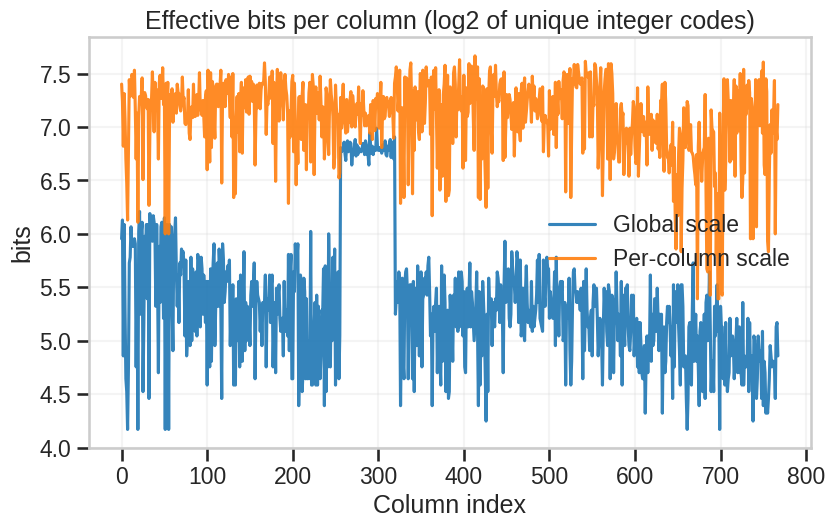

Mean effective bits — Global: 5.35  |  Per-col: 7.08
Columns with higher effective bits using per-column: 99.9%
Median saturation (global): 0.000,  P95: 0.000


In [12]:
viz_quant_distribution(W, qmax=127, top_k_cols=24)

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def quantize_symmetric_global(W, qmax=127):
    # one scale for whole matrix
    s = W.abs().max().clamp_min(1e-8) / qmax
    Wq = torch.clamp(torch.round(W / s), -qmax, qmax).to(torch.int8)
    Wdq = (Wq.float() * s).to(W.dtype)
    return Wq, Wdq, s

def quantize_symmetric_per_column(W, qmax=127):
    # independent scale per column
    s = W.abs().amax(dim=0, keepdim=True).clamp_min(1e-8) / qmax    # [1, n]
    Wq = torch.clamp(torch.round(W / s), -qmax, qmax).to(torch.int8) # broadcast over rows
    Wdq = (Wq.float() * s).to(W.dtype)
    return Wq, Wdq, s.squeeze(0)                                     # s -> [n]

def column_mse(W, W_hat):
    # per-column mean squared error
    return ((W - W_hat).float().pow(2).mean(dim=0)).cpu().numpy()    # [n]

def abs_error(W, W_hat):
    return (W - W_hat).abs().cpu().numpy()


In [14]:
def visualize_quant_compare(W, title_prefix=""):
    # 1) Quantize both ways
    _, Wg, sg = quantize_symmetric_global(W)          # global
    _, Wc, sc = quantize_symmetric_per_column(W)      # per-column

    # 2) Per-column MSE
    mse_g = column_mse(W, Wg)
    mse_c = column_mse(W, Wc)

    # 3) Absolute-error heatmaps (same color scale!)
    Eg = abs_error(W, Wg)
    Ec = abs_error(W, Wc)
    vmax = np.percentile(np.concatenate([Eg.ravel(), Ec.ravel()]), 99.5)  # robust cap

    fig = plt.figure(figsize=(16, 9))

    # --- Heatmaps ---
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=1)
    sns.heatmap(Eg, ax=ax1, cmap="magma", vmin=0, vmax=vmax, cbar=True)
    ax1.set_title(f"{title_prefix} |W - Ŵ| heatmap (Global scale)", fontsize=11)
    ax1.set_xlabel("Column (input)")
    ax1.set_ylabel("Row (output)")

    ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=1)
    sns.heatmap(Ec, ax=ax2, cmap="magma", vmin=0, vmax=vmax, cbar=True)
    ax2.set_title(f"{title_prefix} |W - Ŵ| heatmap (Per-column scale)", fontsize=11)
    ax2.set_xlabel("Column (input)")
    ax2.set_ylabel("Row (output)")

    # --- Per-column MSE line plot ---
    ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
    ax3.plot(mse_g, label="Global", alpha=0.9)
    ax3.plot(mse_c, label="Per-column", alpha=0.9)
    ax3.set_title("Per-column MSE")
    ax3.set_xlabel("Column index")
    ax3.set_ylabel("MSE")
    ax3.legend()
    ax3.grid(alpha=0.2)
    
    plt.tight_layout()
    plt.show()

    # Print quick summary
    print(f"Mean per-column MSE — Global: {mse_g.mean():.4g} | Per-column: {mse_c.mean():.4g}")

/home/tnguyen10/.conda/envs/gpu_env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 770 (\N{COMBINING CIRCUMFLEX ACCENT}) missing from font(s) Liberation Sans.

/tmp/ipykernel_1104462/2067613384.py:40: UserWarning:

Glyph 770 (\N{COMBINING CIRCUMFLEX ACCENT}) missing from font(s) Liberation Sans.

/home/tnguyen10/.conda/envs/gpu_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 770 (\N{COMBINING CIRCUMFLEX ACCENT}) missing from font(s) Liberation Sans.



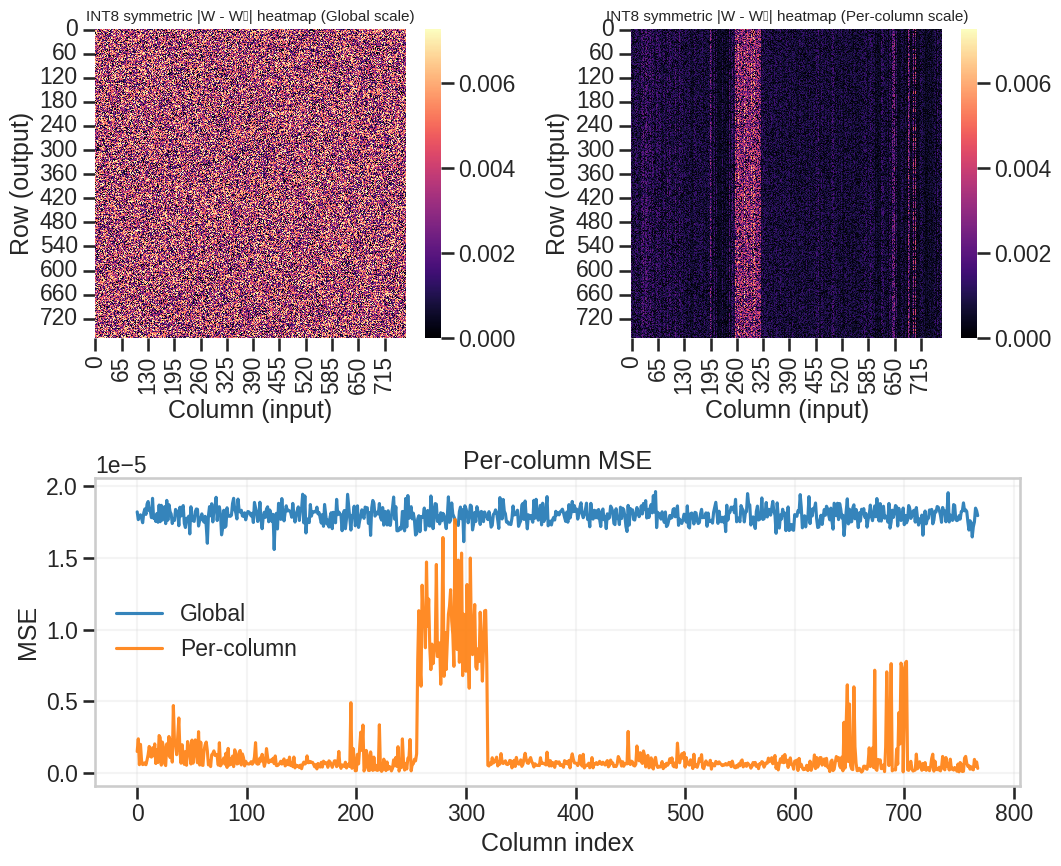

Mean per-column MSE — Global: 1.794e-05 | Per-column: 1.665e-06


In [15]:
visualize_quant_compare(W, title_prefix="INT8 symmetric")